In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import bnl
import random
import matplotlib.pyplot as plt
import numpy as np

In [70]:
tids = bnl.fio.salami_tids()
tid = random.choice(tids)
print(tid)
refs, ests = bnl.fio.salami_annos(tid)

389


In [95]:
from tqdm import tqdm
for tid in tqdm(bnl.fio.salami_tids()):
    bnl.prf.compare_bmetrics_on_refs(tid)

100%|██████████| 1359/1359 [01:24<00:00, 16.03it/s]


In [107]:
import xarray as xr
import os

# bnl.prf.compare_bmetrics_on_refs(384)
nc_files = [f'./ref_boundary_metrics/{f}' for f in os.listdir('./ref_boundary_metrics') if f.endswith('.nc')]
das = [xr.open_dataarray(f) for f in nc_files]
da = xr.concat(das, dim='tid').sortby('tid')
da.name = 'boundary_metrics'
df = da.to_dataframe().reset_index()

In [108]:
da.coords


Coordinates:
  * metric   (metric) object 32B 'hr' 'sr' 'b' 't'
  * perf     (perf) object 24B 'p' 'r' 'f'
  * window   (window) object 16B '0.5' '3'
  * tid      (tid) object 7kB '10' '100' '1000' '1002' ... '997' '998' '999'

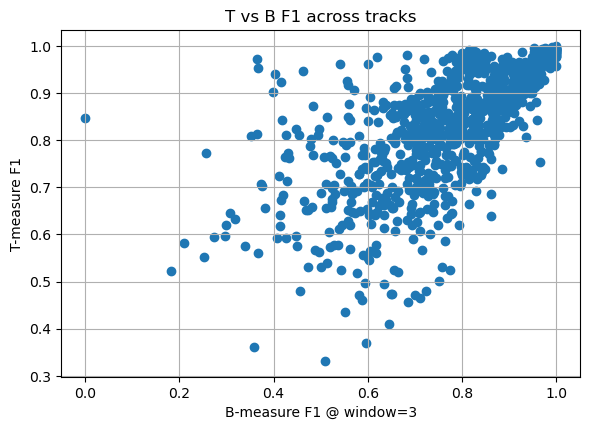

In [143]:
import matplotlib.pyplot as plt

# select f1 of 't' and 'b' at window '3'
t_f1 = da.sel(metric='t', perf='f', window='0.5')
b_f1 = da.sel(metric='b', perf='f', window='3')

# both are now 1-D over 'tid'; pull out the numpy arrays
x = b_f1.values
y = t_f1.values

# make the scatter
plt.figure(figsize=(6,6))
plt.scatter(x, y)
plt.xlabel("B-measure F1 @ window=3")
plt.ylabel("T-measure F1")
plt.title("T vs B F1 across tracks")
plt.grid(True)
plt.tight_layout()
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
for ref in refs.values():
    print('++++++++++++++++++++++++++++++++')
    for window in [0.5,1,3]:
        print('________________________________')
        print(f'Window: {window}')
        
        for est in ests.values():
            scores = bnl.mtr.bmeasure(ref.itvls, est.itvls, trim=False, window=window)
            scores.loc['t'] = bnl.mtr.lmeasure(ref.itvls, ref.labels, est.itvls, est.labels)
            print(scores)

            b_comp = bnl.mtr.bmeasure_components(ref.itvls, est.itvls, trim=False, window=window)
            print(b_comp)

++++++++++++++++++++++++++++++++
__________________________________
Window: 0.5
        prec    recall        f1
hr  0.095238  0.303030  0.144928
sr  0.575758  0.760000  0.655172
b   0.163441  0.433295  0.237352
t   0.504871  0.845152  0.632127
      cap  est  ref
beta   10  105   33
pi     19   33   25
        prec    recall        f1
hr  0.082353  0.212121  0.118644
sr  0.473684  0.750000  0.580645
b   0.140312  0.330709  0.197029
t   0.410447  0.711991  0.520714
      cap  est  ref
beta    7   85   33
pi      9   19   12
        prec    recall        f1
hr  0.091837  0.272727  0.137405
sr  0.642857  1.000000  0.782609
b   0.160714  0.428571  0.233766
t   0.429925  0.736638  0.542961
      cap  est  ref
beta    9   98   33
pi     18   28   18
__________________________________
Window: 1
        prec    recall        f1
hr  0.133333  0.424242  0.202899
sr  0.463768  0.666667  0.547009
b   0.207120  0.518519  0.296003
t   0.504871  0.845152  0.632127
      cap  est  ref
beta   14  105 

In [90]:
def show_t_comp(ref, est):
    t_comp = bnl.mtr.triplet_components(ref.itvls, ref.labels, est.itvls, est.labels)
    # Calculate time points for the steps
    time_points = np.cumsum(t_comp['dur'])
    time_points = np.insert(time_points, 0, 0)  # Add starting point at 0

    # Repeat the last cap, ref, and est values for step plot end
    cap_vals = np.append(t_comp['cap'].values, t_comp['cap'].values[-1])
    ref_vals = np.append(t_comp['ref'].values, t_comp['ref'].values[-1])
    est_vals = np.append(t_comp['est'].values, t_comp['est'].values[-1])

    # Plot step functions for cap, ref, and est
    fig = plt.figure(figsize=(12, 6))
    plt.step(time_points, cap_vals, where='post', label='cap', linewidth=2)
    plt.step(time_points, ref_vals, where='post', label='ref', linewidth=2)
    plt.step(time_points, est_vals, where='post', label='est', linewidth=2)

    # Add labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Calculate max time for proper display
    max_time = time_points[-1]
    plt.xlim(0, max_time)
    return fig

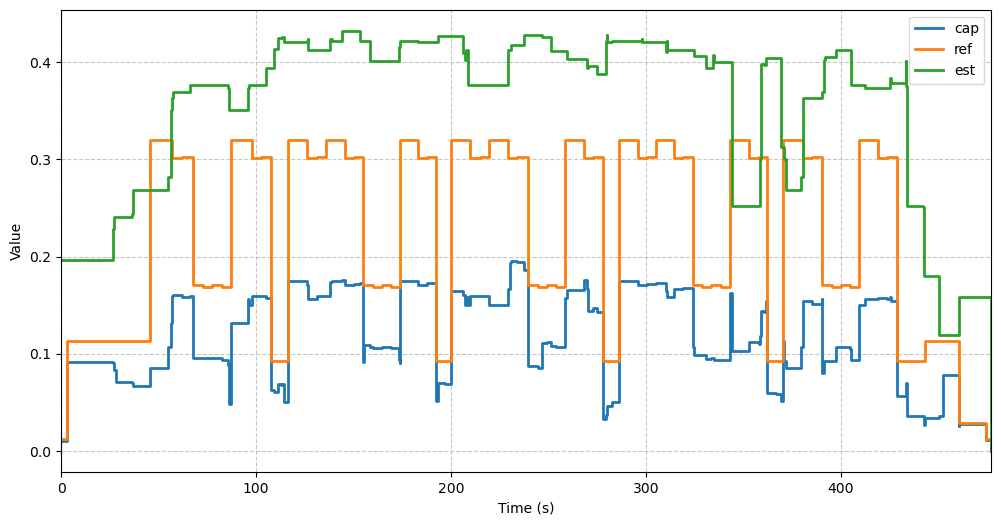

In [91]:
show_t_comp(ref, est);

(<Figure size 500x530 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

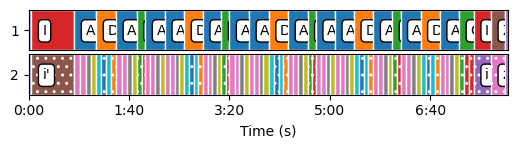

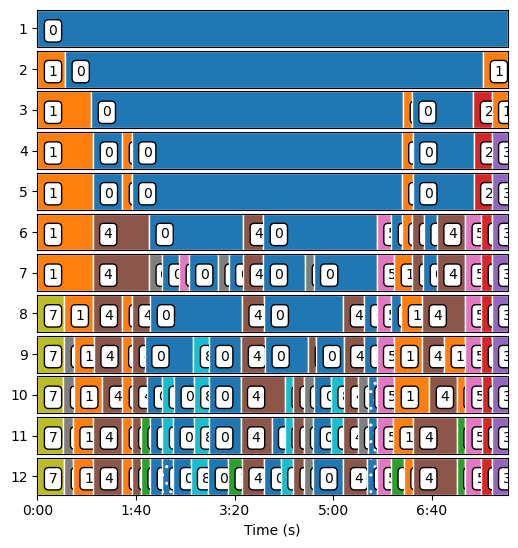

In [92]:
ref.plot()
est.plot()